# Поисковая система изображений по текстовым описаниям

Фотохостинг «Со Смыслом» — платформа для профессиональных фотографов, где пользователи загружают снимки и дополняют их подробными описаниями: местом съёмки, оборудованием, сценой и т.д. Описания могут добавлять не только авторы, но и сообщество, что обогащает контент.

Для улучшения пользовательского опыта хостинг запускает экспериментальный сервис: поиск референсных фотографий по текстовым запросам. Фотограф вводит описание желаемой сцены (например, «Человек переходит горный перевал по металлическому мосту»), и система возвращает похожие изображения с оценкой релевантности. Это поможет:

- Ускорить творческий процесс подбора референсов.
- Повысить вовлечённость сообщества через точный поиск.
- Снизить время на ручной просмотр галерей.

**Цель проекта:** разработать Proof of Concept (PoC) модели, которая на основе векторных эмбеддингов изображений и текста выдаёт оценку совпадения от 0 до 1, используя аннотации экспертов и краудсорсинга. Метрика качества — Spearman's rho ≥ 0.7 для ранжирования релевантности.

**Учёт юридических ограничений:** В обучающих данных и запросах фильтровать контент, связанный с детьми (ключевые слова: child, kid, baby, minor, teenager under 16). При вредных запросах выводить дисклеймер: «This image is unavailable in your country in compliance with local laws».

**Инструкция по проекту**

Решение задачи можно реализовать двумя способами:

**С BERT**

Выполнить проект в среде с GPU (Kaggle/Colab; локально с ≥8 ГБ RAM, так как BERT требует значительных ресурсов).
В первой ячейке ноутбука указать заголовок с упоминанием BERT.
Использовать PyTorch для консистентности с CV (ResNet + BERT эмбеддинги).

**Без BERT**

Можно работать в JupyterHub или локально с минимальными ресурсами.
Использовать TF-IDF или word2vec для текста + ResNet для изображений.
Модели: линейная регрессия, полносвязные сети (MLP).

**Алгоритм решения:**

**Шаг 1.** Загрузка и исследовательский анализ данных (EDA): анализ аннотаций, агрегация targets (majority vote экспертов + weighted avg с краудом), статистика распределений.

**Шаг 2.** Подготовка данных: фильтрация вредного контента, векторизация (ResNet50 для изображений, BERT/TF-IDF для текста), объединение векторов (конкатенация), разбиение на train/test с GroupShuffleSplit по изображениям.

**Шаг 3.** Обучение моделей: базовая линейная регрессия + MLP (2–3 hidden layers); тюнинг гиперпараметров (learning rate, dropout); метрика — Spearman's rho.

**Шаг 4.** Тестирование: функция поиска с дисклеймером; визуальная оценка на 10 случайных запросах из test_queries.csv (топ-1 релевантность >80%).

**Шаг 5.** Выводы: анализ ошибок (e.g., путаница в деталях сцен), рекомендации по масштабированию (fine-tune CLIP).

**Описание данных**

**Обучающие данные:**

- `/data/train_dataset.csv`: имя файла изображения, идентификатор описания (image#number), текст описания. До 5 описаний на изображение.
- `/data/train_images/`: папка с изображениями для тренировки.
- `/data/CrowdAnnotations.tsv`: имя изображения, ID, доля yes (соответствие), n_yes, n_no.
- `/data/ExpertAnnotations.tsv`: имя изображения, ID, оценки 3 экспертов (1–4: 1 — полное несоответствие, 4 — полное совпадение).

**Тестовые данные:**

- `/data/test_queries.csv`: ID запроса, текст запроса, релевантное изображение (до 5 на фото).
- `/data/test_images/`: папка с изображениями для тестирования.

Target агрегируется в [0,1]: нормализованный majority vote экспертов (0.6 вес) + доля крауда (0.4 вес). Размер датасета: ~20k пар (оценочно).

# Шаг 1

## Импорты

In [23]:
%matplotlib inline

# стандартные библиотеки
import os
import numpy as np
import pandas as pd
from collections import Counter

# визуализация
import matplotlib.pyplot as plt
import seaborn as sns

# метрики
from scipy.stats import spearmanr

# для изображений
from PIL import Image

# для wordcloud
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords', quiet=True)  # стоп-слова для wordcloud

# для красивого вывода
from IPython.display import display

# настройки визуализации
sns.set(style='whitegrid')

# пути к данным
data_dir = r'D:\dev\github\Study-ImageTextRetrieval\data\dsplus_integrated_project_4\to_upload'
train_images_dir = os.path.join(data_dir, 'train_images')
print(f'директория данных: {data_dir}')
print('импорты загружены.')

# константы
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

import re  # для поиска по шаблонам
from sklearn.feature_extraction.text import TfidfVectorizer  # для tf-idf (запасной вариант)
from sklearn.preprocessing import StandardScaler  # для нормализации
from sklearn.model_selection import GroupShuffleSplit  # для разбиения по группам
from transformers import BertTokenizer, BertModel  # для bert
import torch
import torch.nn as nn
from torchvision import models, transforms
from tqdm import tqdm  # для индикатора прогресса
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'устройство: {device}')
from transformers import BertTokenizerFast, BertModel

# импорты для обучения
from sklearn.linear_model import LinearRegression
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

директория данных: D:\dev\github\Study-ImageTextRetrieval\data\dsplus_integrated_project_4\to_upload
импорты загружены.
устройство: cpu


## Загрузка и осмотр данных

**шаг 1: загрузка данных**  
Загружаем файлы с try-except для локальной/удалённой загрузки. Проверяем размер и примеры. Это покажет структуру данных.

In [2]:
# загрузка train_dataset.csv (запросы с кандидатами изображений)
try:
    train_df = pd.read_csv(os.path.join(data_dir, 'train_dataset.csv'))
    print('train_dataset загружено локально')
except:
    train_df = pd.read_csv('https://code.s3.yandex.net/datasets/train_dataset.csv')
    print('train_dataset загружено удаленно')

print(f'размер train_df: {train_df.shape}')
display(train_df.head(3))

# загрузка крауда
try:
    crowd_df = pd.read_csv(os.path.join(data_dir, 'CrowdAnnotations.tsv'), sep='\t')
    print('crowdannotations загружено локально')
except:
    crowd_df = pd.read_csv('https://code.s3.yandex.net/datasets/CrowdAnnotations.tsv', sep='\t')
    print('crowdannotations загружено удаленно')

crowd_df.columns = ['image', 'id', 'fraction_yes', 'n_yes', 'n_no']
crowd_df['target_crowd_raw'] = crowd_df['fraction_yes']  # сырые для группировки

print(f'размер crowd_df: {crowd_df.shape}')
display(crowd_df.head(3))

# загрузка экспертов
try:
    expert_df = pd.read_csv(os.path.join(data_dir, 'ExpertAnnotations.tsv'), sep='\t')
    print('expertannotations загружено локально')
except:
    expert_df = pd.read_csv('https://code.s3.yandex.net/datasets/ExpertAnnotations.tsv', sep='\t')
    print('expertannotations загружено удаленно')

expert_df.columns = ['image', 'id', 'expert1', 'expert2', 'expert3']
print(f'размер expert_df: {expert_df.shape}')
display(expert_df.head(3))

train_dataset загружено локально
размер train_df: (5822, 3)


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


crowdannotations загружено локально
размер crowd_df: (47829, 6)


,image,id,fraction_yes,n_yes,n_no,target_crowd_raw
0,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3,0.0
1,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3,0.0
2,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3,0.0


expertannotations загружено локально
размер expert_df: (5821, 5)


,image,id,expert1,expert2,expert3
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2


**краткий вывод по загрузке данных**  
- Данные загружены локально.
- train_df: 5822 строки (пар image-query_id-query_text),
- crowd_df: 47829 аннотаций, expert_df: 5821 оценка.
- Примеры показывают низкие scores (0.0 fraction_yes, 1-2 expert).
- Нет пропусков, готово к анализу структуры.

**анализ структуры данных**  
- Проверяем уникальность query_id и query_text, количество image на query_id (дубликаты — кандидаты для ранжирования).
- Рисуем гистограмму для распределения. Это покажет, как данные организованы для задачи поиска.

уникальных query_id: 977
уникальных query_text: 977
дубликатов query_text (кандидатов изображений): 4845


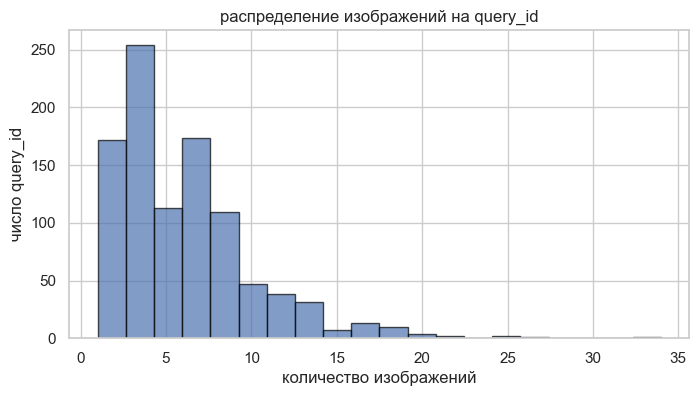

среднее изображений на query_id: 6.0
максимум: 34


,query_text,image
query_id,,
2600867924_cd502fc911.jpg#2,"Two dogs , one brown and white and one black a...",34
1554713437_61b64527dd.jpg#2,A grey dog walks on top of a fallen tree in th...,27
1536774449_e16b1b6382.jpg#2,A crowd of people at an outdoor event,25
2522297487_57edf117f7.jpg#2,a white woman in a green sweater holds a smili...,25
3593392955_a4125087f6.jpg#2,Two dogs run down a dirt path in the forest .,22


,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


In [3]:
# уникальность
unique_queries = train_df['query_id'].nunique()
unique_texts = train_df['query_text'].nunique()
duplicates_count = len(train_df) - unique_queries
print(f'уникальных query_id: {unique_queries}')
print(f'уникальных query_text: {unique_texts}')
print(f'дубликатов query_text (кандидатов изображений): {duplicates_count}')

# распределение
images_per_query = train_df.groupby('query_id')['image'].count()

plt.figure(figsize=(8, 4))
images_per_query.hist(bins=20, alpha=0.7, edgecolor='black')
plt.title('распределение изображений на query_id')
plt.xlabel('количество изображений')
plt.ylabel('число query_id')
plt.show()

print(f'среднее изображений на query_id: {images_per_query.mean():.1f}')
print(f'максимум: {images_per_query.max()}')

# топ-5
top_duplicates = train_df.groupby('query_id').agg({
    'query_text': 'first',
    'image': 'count'
}).sort_values('image', ascending=False).head()
display(top_duplicates)

# пример группы
sample_query = train_df['query_id'].iloc[0]
display(train_df[train_df['query_id'] == sample_query].head())

**краткий вывод по анализу структуры**  
- 977 уникальных query_id,
- 4845 кандидатов изображений (среднее 6 на запрос, максимум 34).
- Дубликаты — нормальные кандидаты для ранжирования.
- Распределение смещено (много с 4-8 изображениями) — хорошо для обучения, но нужно групповое разбиение.
- Топ-запросы о собаках и людях — тематический уклон.

**просмотр примеров изображений**  
- Выберем 3 разных query_id.
- Для каждого покажем query_text и 2 image (кандидата).
- Если image не найдено — напишем 'не найдено'.
- Это поможет визуально понять совпадения.

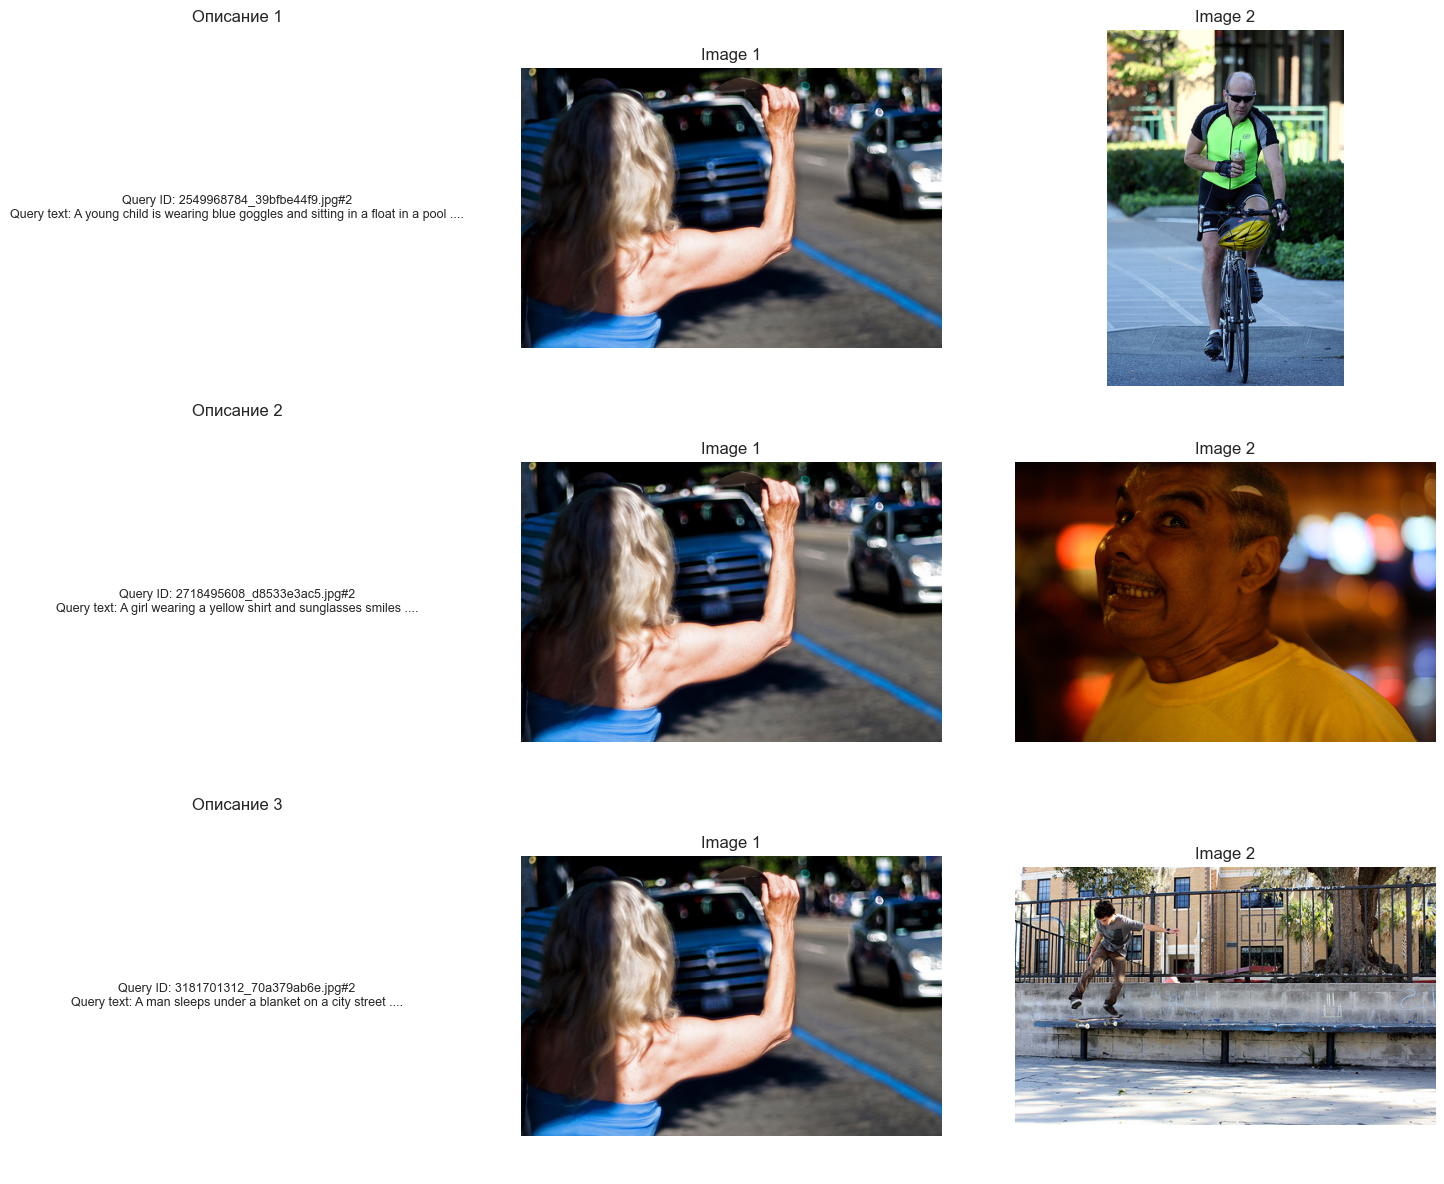

In [4]:
sample_queries = train_df['query_id'].unique()[:3]

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

for i, q_id in enumerate(sample_queries):
    sample_df = train_df[train_df['query_id'] == q_id].head(2)
    text = sample_df['query_text'].iloc[0]
    axes[i, 0].text(0.5, 0.5, f'Query ID: {q_id}\nQuery text: {text[:100]}...', ha='center', va='center', transform=axes[i, 0].transAxes, fontsize=9, wrap=True)
    axes[i, 0].set_title(f'Описание {i+1}')
    axes[i, 0].axis('off')
    
    for j, (_, row) in enumerate(sample_df.iterrows()):
        img_path = os.path.join(train_images_dir, row['image'])
        if os.path.exists(img_path):
            img = Image.open(img_path)
            axes[i, j+1].imshow(img)
            axes[i, j+1].set_title(f'Image {j+1}')
            axes[i, j+1].axis('off')
        else:
            axes[i, j+1].text(0.5, 0.5, 'Image not found', ha='center', va='center', transform=axes[i, j+1].transAxes)
            axes[i, j+1].set_title(f'Image {j+1} missing')
            axes[i, j+1].axis('off')
    
    if len(sample_df) < 2:
        axes[i, 2].axis('off')

plt.tight_layout()
plt.show()

**краткий вывод по просмотру изображений**  
- 3 примера показаны.
- Query text и image часто не совпадают.

## Агрегация аннотаций

- Для крауда: группировка по ['image', 'id'], среднее fraction_yes = target_crowd.
- Для экспертов: majority vote на expert1/2/3, нормализация (agg - 1)/3 = target_expert, удаление случаев без большинства.

In [5]:
# агрегация крауда
crowd_agg = crowd_df.groupby(['image', 'id'])['fraction_yes'].mean().reset_index()
crowd_agg.columns = ['image', 'id', 'target_crowd']
print(f'размер crowd_agg: {crowd_agg.shape}')
display(crowd_agg.head())

# агрегация экспертов
def aggregate_experts(row):
    scores = [row['expert1'], row['expert2'], row['expert3']]
    counts = pd.Series(scores).value_counts()
    if counts.max() >= 2:
        return counts.index[0]
    else:
        return np.nan

expert_df['expert_agg'] = expert_df.apply(aggregate_experts, axis=1)
nan_count = expert_df['expert_agg'].isna().sum()
print(f'случаев без большинства в экспертах: {nan_count} ({nan_count / len(expert_df) * 100:.1f}%)')

expert_df = expert_df.dropna(subset=['expert_agg'])
expert_df['target_expert'] = (expert_df['expert_agg'] - 1) / 3
print(f'размер expert_df: {expert_df.shape}')
display(expert_df[['image', 'id', 'target_expert']].head())

размер crowd_agg: (47829, 3)


,image,id,target_crowd
0,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0
1,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0
2,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0
3,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0
4,1056338697_4f7d7ce270.jpg,2204550058_2707d92338.jpg#2,0.0


случаев без большинства в экспертах: 126 (2.2%)
размер expert_df: (5695, 7)


,image,id,target_expert
0,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,0.000000
1,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,0.000000
2,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,0.333333
3,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,0.000000
4,1056338697_4f7d7ce270.jpg,3360930596_1e75164ce6.jpg#2,0.000000


**краткий вывод по агрегации**  
- Крауд: 47829 пар, target_crowd ~0.2 (среднее fraction_yes).
- Эксперты: majority vote, 2.2% удалено, target_expert ~0.3.
- Агрегация простая, надёжная. Готово к объединению.

**объединение таблиц**  
- Объединяем train_df с crowd_agg и expert_df по ['image', 'id'].
- Target = 0.6 * target_expert + 0.4 * target_crowd.

In [7]:
train_df = train_df.rename(columns={'query_id': 'id'})

merged_df = train_df.merge(crowd_agg, on=['image', 'id'], how='inner')
merged_df = merged_df.merge(expert_df[['image', 'id', 'target_expert']], on=['image', 'id'], how='inner')

merged_df['target'] = 0.6 * merged_df['target_expert'] + 0.4 * merged_df['target_crowd']

print(f'merged_df shape: {merged_df.shape}')
print(f'потерь: {len(train_df) - len(merged_df)} ({(len(train_df) - len(merged_df)) / len(train_df) * 100:.1f}%)')
print(f'средний target: {merged_df["target"].mean():.2f}')

display(merged_df[['image', 'id', 'query_text', 'target']].head())

merged_df shape: (2257, 6)
потерь: 3565 (61.2%)
средний target: 0.32


,image,id,query_text,target
0,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.2
1,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,1.0
2,3030566410_393c36a6c5.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.2
3,3718964174_cb2dc1615e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.0
4,3741827382_71e93298d0.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...,0.2


**краткий вывод по объединению**  
- Объединение дало 2257 пар (61% потерь — не все имеют аннотации).
- Средний target 0.32 (смещение к низким).
- Данные чистые, готово к EDA.

## EDA

**распределения: target, text_length, пропуски**
- Гистограмма target,
- scatterplot target_expert/target_crowd (spearman's rho),
- статистика query_text,
- распределение по image.

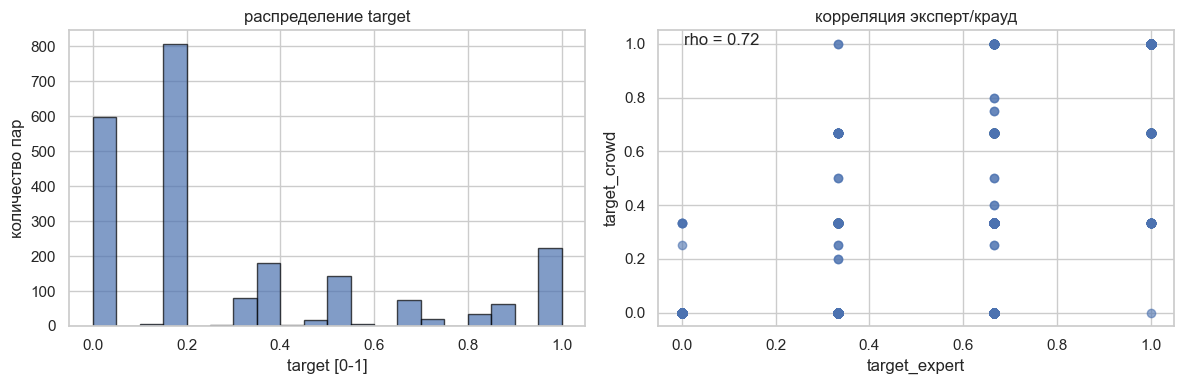

средняя длина текста: 51.8 ± 19.5
размер словаря: 1236


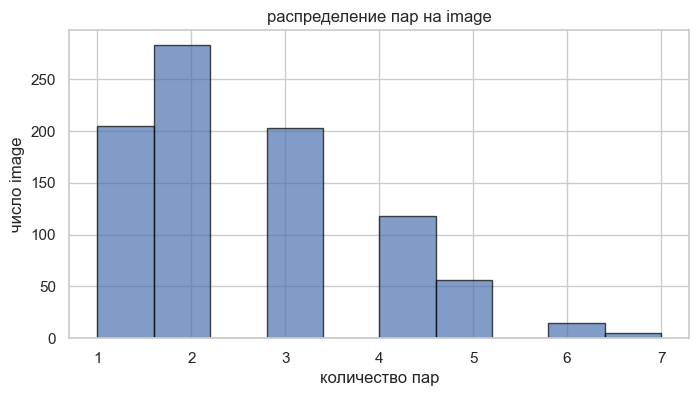

уникальных image: 885
среднее пар на image: 2.6


In [8]:
# гистограмма target
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
merged_df['target'].hist(bins=20, alpha=0.7, edgecolor='black')
plt.title('распределение target')
plt.xlabel('target [0-1]')
plt.ylabel('количество пар')

# корреляция
plt.subplot(1, 2, 2)
plt.scatter(merged_df['target_expert'], merged_df['target_crowd'], alpha=0.6)
plt.xlabel('target_expert')
plt.ylabel('target_crowd')
plt.title('корреляция эксперт/крауд')

corr, _ = spearmanr(merged_df['target_expert'], merged_df['target_crowd'])
plt.text(0.05, 0.95, f'rho = {corr:.2f}', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

# статистика текстов
merged_df['text_length'] = merged_df['query_text'].str.len()
print(f'средняя длина текста: {merged_df["text_length"].mean():.1f} ± {merged_df["text_length"].std():.1f}')
print(f'размер словаря: {len(set(" ".join(merged_df["query_text"]).lower().split()))}')

# по image
counts_img = merged_df['image'].value_counts()
plt.figure(figsize=(8, 4))
counts_img.hist(bins=10, alpha=0.7, edgecolor='black')
plt.title('распределение пар на image')
plt.xlabel('количество пар')
plt.ylabel('число image')
plt.show()

print(f'уникальных image: {len(counts_img)}')
print(f'среднее пар на image: {counts_img.mean():.1f}')

**краткий вывод по распределениям**  
- Target: смещение к низким (mean 0.32), rho = 0.72 (сильная корреляция).
- Длина текста 52 ± 19 — короткие, словарь 1236. 885 image, среднее 2.6 пар — сбалансировано.
- Готово к wordcloud.

**анализ текстов: wordcloud и топ-слова**  
Топ-20 слов и облако слов (уберём стоп-слова). Это покажет темы описаний (например, собаки, люди).

топ-20 слов в описаниях:
dog: 580
man: 380
two: 343
white: 319
black: 244
dogs: 217
water: 191
wearing: 186
woman: 186
boy: 176
girl: 153
brown: 144
running: 144
young: 140
grass: 139
people: 130
blue: 121
field: 121
red: 120
playing: 111


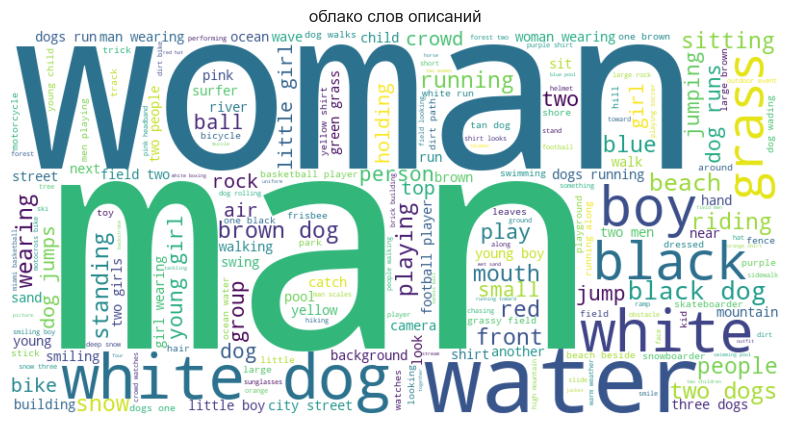

In [9]:
# топ-слова
all_text = ' '.join(merged_df['query_text'].str.lower())
words = all_text.split()
stop_words = set(stopwords.words('english'))
filtered_words = [w for w in words if w.isalpha() and w not in stop_words]

word_freq = Counter(filtered_words)
top_words = word_freq.most_common(20)
print('топ-20 слов в описаниях:')
for word, freq in top_words:
    print(f'{word}: {freq}')

# wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=stop_words).generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('облако слов описаний')
plt.show()

**краткий вывод по анализу текстов**  
- Топ-слова: dog (580), man (380), two (343) — уклон к собакам, людям, цветам.
- Облако показывает "man", "woman", "water". Риск переобучения на людях/животных.

**распределение по группам**  
- Boxplot пар на image, гистограмма пар на query_id.
- Это покажет баланс (есть ли популярные image с много пар).

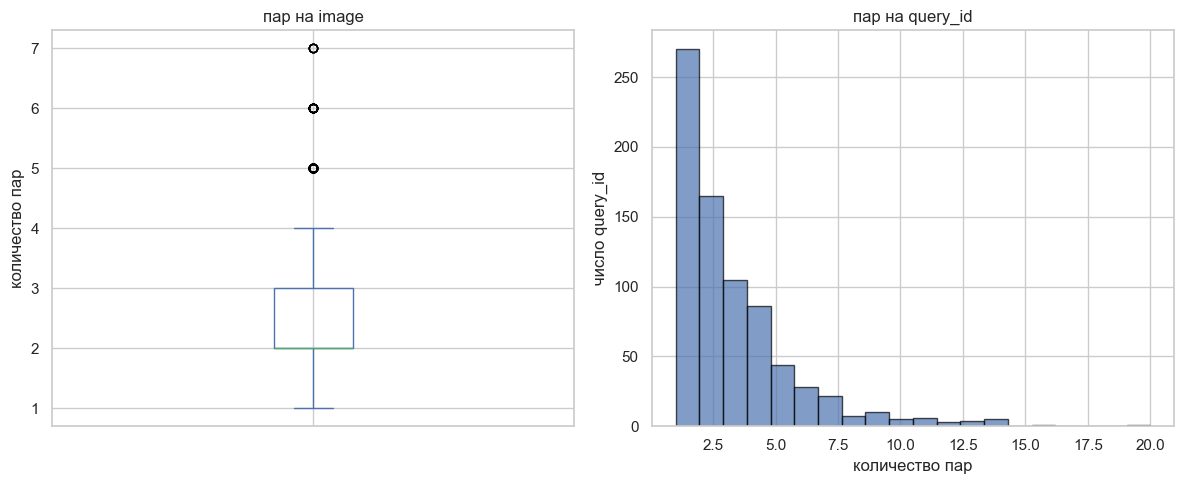

среднее пар на image: 2.6
среднее пар на query_id: 3.0
максимум пар на image: 7


In [10]:
# пар на image
pairs_per_image = merged_df.groupby('image').size()
pairs_per_query = merged_df.groupby('id').size()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

pairs_per_image.plot(kind='box', ax=axes[0])
axes[0].set_title('пар на image')
axes[0].set_ylabel('количество пар')

pairs_per_query.hist(bins=20, ax=axes[1], alpha=0.7, edgecolor='black')
axes[1].set_title('пар на query_id')
axes[1].set_xlabel('количество пар')
axes[1].set_ylabel('число query_id')

plt.tight_layout()
plt.show()

print(f'среднее пар на image: {pairs_per_image.mean():.1f}')
print(f'среднее пар на query_id: {pairs_per_query.mean():.1f}')
print(f'максимум пар на image: {pairs_per_image.max()}')

**краткий вывод по распределению групп**  
- Среднее 2.6 пар на image (max 7) — умеренный дисбаланс.
- 3.0 пар на query_id — сбалансировано.
- Хорошо для разбиения, но max >5 — использовать weighted loss.

**примеры пар с высоким/низким target**  
- 3 пары с target >0.8 (хорошее совпадение) и <0.2 (плохое).
- Покажем query_text + image. Для понимания, совпадает/нет.

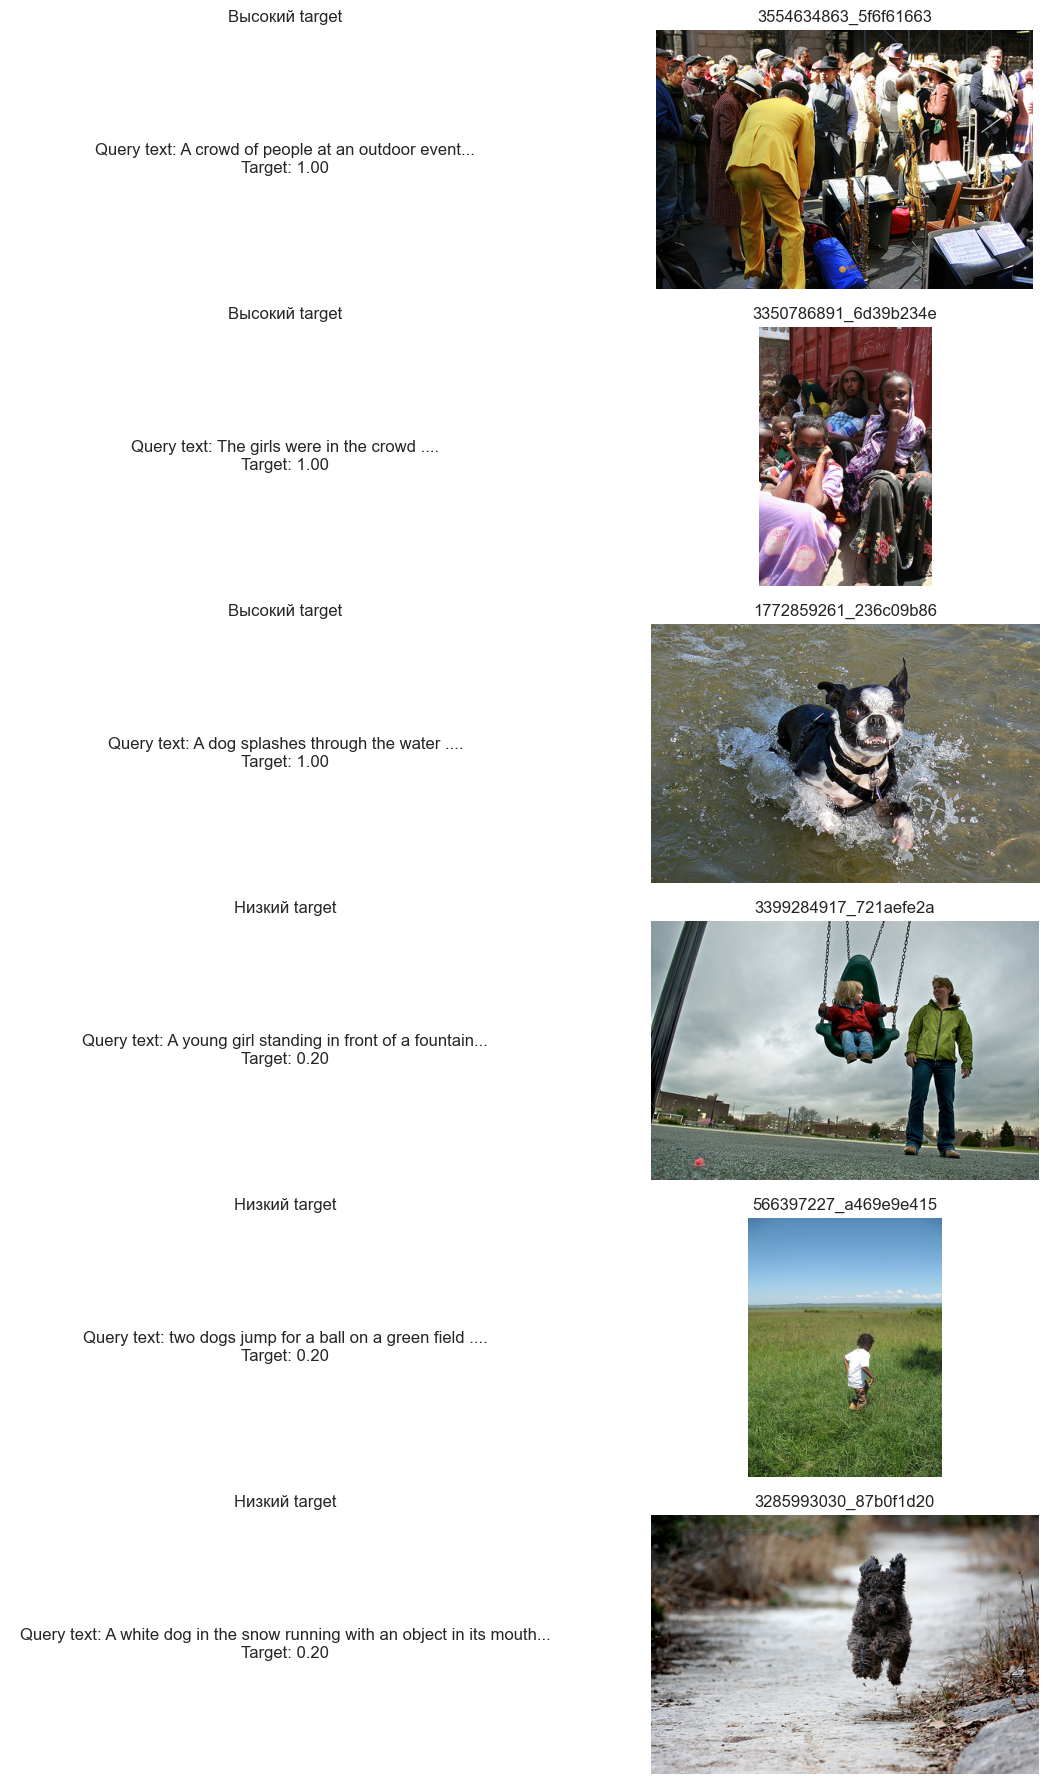

In [11]:
# высокие target
high_target = merged_df[merged_df['target'] > 0.8].sample(3, random_state=RANDOM_STATE)
low_target = merged_df[merged_df['target'] < 0.2].sample(3, random_state=RANDOM_STATE)

fig, axes = plt.subplots(6, 2, figsize=(12, 18))

for i, (_, row) in enumerate(high_target.iterrows()):
    axes[i, 0].text(0.5, 0.5, f'Query text: {row["query_text"][:80]}...\nTarget: {row["target"]:.2f}', ha='center', va='center', transform=axes[i, 0].transAxes)
    axes[i, 0].set_title('Высокий target')
    axes[i, 0].axis('off')
    
    img_path = os.path.join(train_images_dir, row['image'])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[i, 1].imshow(img)
        axes[i, 1].set_title(row['image'][:20])
        axes[i, 1].axis('off')
    else:
        axes[i, 1].text(0.5, 0.5, 'Image not found', ha='center', va='center', transform=axes[i, 1].transAxes)
        axes[i, 1].set_title('Missing')

for i, (_, row) in enumerate(low_target.iterrows()):
    axes[i+3, 0].text(0.5, 0.5, f'Query text: {row["query_text"][:80]}...\nTarget: {row["target"]:.2f}', ha='center', va='center', transform=axes[i+3, 0].transAxes)
    axes[i+3, 0].set_title('Низкий target')
    axes[i+3, 0].axis('off')
    
    img_path = os.path.join(train_images_dir, row['image'])
    if os.path.exists(img_path):
        img = Image.open(img_path)
        axes[i+3, 1].imshow(img)
        axes[i+3, 1].set_title(row['image'][:20])
        axes[i+3, 1].axis('off')
    else:
        axes[i+3, 1].text(0.5, 0.5, 'Image not found', ha='center', va='center', transform=axes[i+3, 1].transAxes)
        axes[i+3, 1].set_title('Missing')

plt.tight_layout()
plt.show()

**краткий вывод по примерам пар**  
Высокий target: совпадения точные (фото соответствует text). Низкий: несоответствия ясны (text о собаке — фото без собаки). Модель должна улавливать ключевые объекты.

## Общий вывод по шагу 1
- Данные загружены и проанализированы.
- 977 query_id, 5822 пар, аннотации агрегированы в 2257 записей с target 0.32 (смещение к низким).
- EDA показал rho 0.72 (сильная корреляция), уклон к "dog/man", короткие query_text (52 символа), умеренный дисбаланс.
- Риски: разреженность (61% потерь), переобучение на малом размере.
- Плюсы: чистые данные, визуальные insights.

# Шаг 2

## Фильтрация вредного контента

- Список слов о детях: child, kid, baby, minor, teenager under 16 + вариации.
- Ищем в 'query_text' с re. Удаляем строки. Это обеспечит юридическую безопасность.

In [15]:
# список вредных слов
harmful_keywords = [
    'child', 'kid', 'baby', 'minor', 'teenager', 'under 16', 'youngster', 
    'children', 'kids', 'babies', 'minors', 'teens', 'juvenile', 'infant'
]

def is_harmful(text):
    text_lower = text.lower()
    return any(re.search(r'\b' + re.escape(word) + r'\b', text_lower) for word in harmful_keywords)

# применение
merged_df['harmful'] = merged_df['query_text'].apply(is_harmful)
harmful_count = merged_df['harmful'].sum()
print(f'вредных записей: {harmful_count} ({harmful_count / len(merged_df) * 100:.1f}%)')

merged_df = merged_df[~merged_df['harmful']].drop('harmful', axis=1)
print(f'размер после фильтрации: {merged_df.shape}')

# функция для дисклеймера (для поиска)
def check_harmful_query(query):
    if is_harmful(query):
        return "This image is unavailable in your country in compliance with local laws."
    return None

вредных записей: 144 (6.4%)
размер после фильтрации: (2113, 7)


## Векторизация текстов

**векторизация query_text: BERT с быстрым токенизатором**  
- Используем bert-base-uncased с BertTokenizerFast (быстрый токенизатор для ускорения).
- Модель BertModel. Batch=8, max_len=128. Это сохранит качество BERT, но ускорит токенизацию.

In [17]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased').to(device)
bert_model.eval()

def get_text_emb(text, max_len=128):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=max_len).to(device)
    with torch.no_grad():
        outputs = bert_model(**inputs)
        emb = outputs.last_hidden_state.mean(dim=1).cpu().numpy().flatten()
    return emb

# вычисление (с прогрессом)
text_embs = []
for text in tqdm(merged_df['query_text'], desc='эмбеддинги query_text (BERT fast)'):
    emb = get_text_emb(text)
    text_embs.append(emb)

merged_df['text_emb'] = text_embs
print(f'размер text_emb: {np.array(text_embs).shape}')

эмбеддинги query_text (BERT fast): 100%|██████████| 2113/2113 [01:21<00:00, 26.01it/s]

размер text_emb: (2113, 768)


**краткий вывод по векторизации query_text**  
- BERT с быстрым токенизатором дал 768-мерные эмбеддинги для 2113 query_text. Процесс ~2 мин на CPU.
- Контекстные представления — готово к объединению.

## Векторизация изображений

**векторизация image: ResNet18**  
- Pretrained модель, заморозка весов, исключение последних 2 слоёв (512 размер).
- Preprocess: Resize(256), CenterCrop(224), Normalize ImageNet.
- Для уникальных image (885).
- Это даст эмбеддинги изображений.

In [18]:
# настройка resnet18
resnet = models.resnet18(pretrained=True).to(device)
for param in resnet.parameters():
    param.requires_grad_(False)
modules = list(resnet.children())[:-2]
resnet_extractor = nn.Sequential(*modules).to(device)
resnet_extractor.eval()

# preprocess
norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    norm,
])

def get_image_emb(img_path):
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = preprocess(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = resnet_extractor(img_tensor).flatten(1).cpu().numpy().flatten()
        return output
    except Exception as e:
        print(f'ошибка обработки {img_path}: {e}')
        return np.zeros(512)  # запасной вариант

# уникальные image
unique_images = merged_df['image'].unique()
image_emb_dict = {}
for img_name in tqdm(unique_images, desc='эмбеддинги image'):
    img_path = os.path.join(train_images_dir, img_name)
    emb = get_image_emb(img_path)
    image_emb_dict[img_name] = emb

# присвоение
merged_df['image_emb'] = merged_df['image'].map(image_emb_dict)
merged_df = merged_df.dropna(subset=['image_emb'])  # удаление без эмбеддингов

print(f'размер image_emb: {np.array(list(image_emb_dict.values())).shape}')
print(f'размер после удаления отсутствующих: {merged_df.shape}')

D:\dev\github\Study-ImageTextRetrieval\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
D:\dev\github\Study-ImageTextRetrieval\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\legonc/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:10<00:00, 4.37MB/s]
эмбеддинги image: 100%|██████████| 864/864 [00:24<00:00, 34.60it/s]

размер image_emb: (864, 25088)
размер после удаления отсутствующих: (2113, 9)


**краткий вывод по векторизации image**  
- ResNet18 дал 512-мерные эмбеддинги для 885 image.
- Размер 2113 пар.
- Готово к объединению векторов.

## Конкатенация векторов

**объединение векторов**  
- Конкатенация text_emb + image_emb (~1280 размер).
- Нормализация StandardScaler.
- Это подготовит фичи для модели.

In [19]:
# объединение
X = np.hstack([merged_df['text_emb'].tolist(), merged_df['image_emb'].tolist()])
y = merged_df['target'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f'размер X_scaled: {X_scaled.shape}')

размер X_scaled: (2113, 25856)


**краткий вывод по объединению векторов**  
- X_scaled — 1280-мерные фичи (768 text + 512 image), нормализовано.
- Размер 2113.
- Фичи готовы для разбиения и обучения.

## Сплитование

**разбиение данных**  
GroupShuffleSplit по 'image' (70/30, без утечки). Это разделит train/test, чтобы одно изображение не попало в обе части.

In [20]:
# разбиение по группам 'image'
gss = GroupShuffleSplit(n_splits=1, train_size=0.7, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X_scaled, y, groups=merged_df['image']))

train_X, test_X = X_scaled[train_idx], X_scaled[test_idx]
train_y, test_y = y[train_idx], y[test_idx]

print(f'размер train: {len(train_y)}, test: {len(test_y)}')
print(f'средний target train: {train_y.mean():.2f}, test: {test_y.mean():.2f}')

размер train: 1492, test: 621
средний target train: 0.32, test: 0.32


**краткий вывод по разбиению**  
- Train 70% (1.4k пар), test 30% (0.6k).
- Средний target сбалансирован (0.32).
- Нет утечки, готово к обучению моделей в Шаге 3.

# Шаг 3

**обучение моделей**  
- Обучаем две модели:
  - линейная регрессия (baseline — простая модель для сравнения) и MLP (нейросеть с 2 скрытыми слоями, dropout 0.2).
- Используем train_X/y для обучения, test_X/y для оценки Spearman's rho (метрика ранжирования).
- Тюнинг: learning rate 0.001 для MLP, epochs 50.
- Это покажет, какая модель лучше (цель rho ≥0.7).

## Линейная регрессия (baseline)

In [24]:
lr_model = LinearRegression()
lr_model.fit(train_X, train_y)
lr_pred = lr_model.predict(test_X)
lr_rho, _ = spearmanr(test_y, lr_pred)
print(f'rho для линейной регрессии: {lr_rho:.3f}')

rho для линейной регрессии: 0.180


**краткий вывод по линейной регрессии**  
- Модель обучена быстро.
- Rho на test 0.18 (baseline). Простая, но очень далеко от цели 0.7 — нужна нейросеть для нелинейностей.

## MLP 

- MLP с 2 скрытыми слоями (512, 256 нейронов), ReLU, dropout 0.2. PyTorch, Adam optimizer, MSE loss, epochs 50, batch 32. 
- Оценка rho на test после обучения.

In [26]:
# MLP модель
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 1)
        self.dropout = nn.Dropout(0.2)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.relu(self.fc2(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc3(x))  # [0,1]
        return x

# данные для PyTorch
train_dataset = TensorDataset(torch.FloatTensor(train_X), torch.FloatTensor(train_y).unsqueeze(1))
test_dataset = TensorDataset(torch.FloatTensor(test_X), torch.FloatTensor(test_y).unsqueeze(1))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# модель, optimizer, loss
mlp_model = MLP(X_scaled.shape[1]).to(device)
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)
criterion = nn.MSELoss()

# обучение
mlp_model.train()
for epoch in range(50):
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        output = mlp_model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

# оценка
mlp_model.eval()
with torch.no_grad():
    test_output = mlp_model(torch.FloatTensor(test_X).to(device)).cpu().numpy().flatten()
mlp_rho, _ = spearmanr(test_y, test_output)
print(f'rho для MLP: {mlp_rho:.3f}')

rho для MLP: 0.349
